# Simple usage of v_PVMismatch

In [1]:
import numpy as np
import copy

v_PVMismatch is a vectorized version of SunPower's [PVMismatch](https://sunpower.github.io/PVMismatch/). The package comes pre-packaged with the original version of PVMismatch. Let's load a default module from the PVMismatch.

## Usage of the original classes of PVMismatch

The code below is directly taken from PVMismatch documentation linked above.

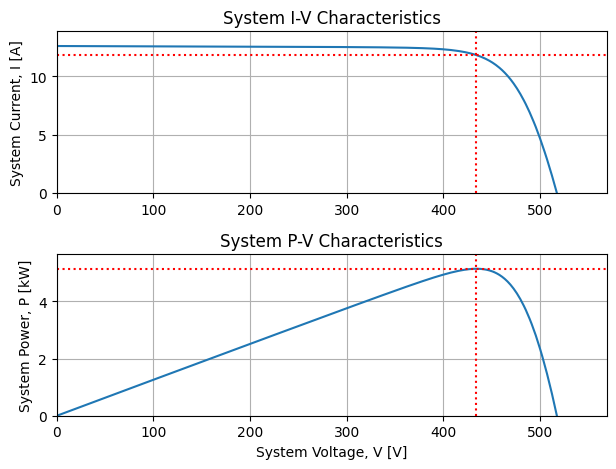

In [2]:
from v_pvmismatch.pvmismatch import *  # this imports everything we need
pvsys = pvsystem.PVsystem(numberStrs=2, numberMods=8)  # makes the system
f = pvsys.plotSys()  # creates a figure with the system IV & PV curve

In [3]:
pvsys.Vmp  # max voltage [V]

434.48798636176406

In [4]:
pvsys.Imp  # max current [A]

11.830537445288693

In [5]:
pvsys.Pmp  # max power [W]

5140.226392180933

In [6]:
pvsys.FF  # fill factor

np.float64(0.7872605537172069)

In [7]:
pvsys.eff  # efficiency

np.float64(0.2182548462407528)

In [8]:
pvsys.Voc  # open circuit voltage [V]

np.float64(517.7348052299848)

In [9]:
pvsys.Isc  # short circuit current [A]

np.float64(12.611199442247422)

### Now lets shade the last row of the 1st module in the 1st string:

In [10]:
pvsys.setSuns({0: {0: [(0.2, ) * 8, (11, 12, 35, 36, 59, 60, 83, 84)]}})

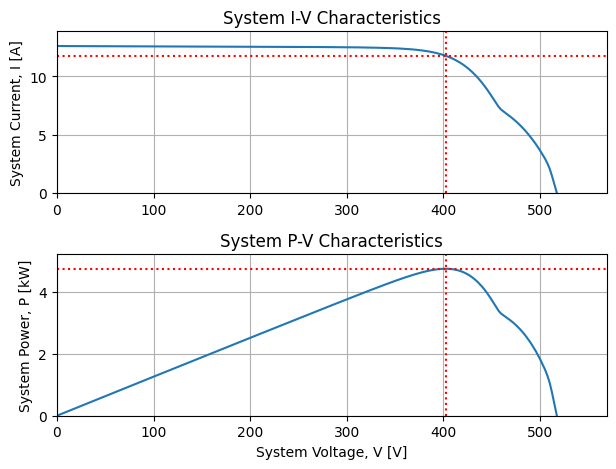

In [11]:
f_shade = pvsys.plotSys()

## Let's now use v_PVMismatch

PVMismatch allows calculating the I-V and P-V curves for a single time instant. With v_PVMismatch we can do this for multiple time instances. The package uses most of the basic data structures from PVMismatch. Let's extract these.

### Create unshaded PVSystem

In [12]:
num_str = 2
str_len = 8
pvsys = pvsystem.PVsystem(numberStrs=num_str, numberMods=str_len)  # makes the system

### PV Module

In [13]:
pvmodule = pvsys.pvmods[0][0]

### Cell position

In [14]:
cell_pos = pvmodule.cell_pos
cell_pos

[[[{'crosstie': False, 'idx': 0},
   {'crosstie': False, 'idx': 1},
   {'crosstie': False, 'idx': 2},
   {'crosstie': False, 'idx': 3},
   {'crosstie': False, 'idx': 4},
   {'crosstie': False, 'idx': 5},
   {'crosstie': False, 'idx': 6},
   {'crosstie': False, 'idx': 7},
   {'crosstie': False, 'idx': 8},
   {'crosstie': False, 'idx': 9},
   {'crosstie': False, 'idx': 10},
   {'crosstie': False, 'idx': 11}],
  [{'crosstie': False, 'idx': 23},
   {'crosstie': False, 'idx': 22},
   {'crosstie': False, 'idx': 21},
   {'crosstie': False, 'idx': 20},
   {'crosstie': False, 'idx': 19},
   {'crosstie': False, 'idx': 18},
   {'crosstie': False, 'idx': 17},
   {'crosstie': False, 'idx': 16},
   {'crosstie': False, 'idx': 15},
   {'crosstie': False, 'idx': 14},
   {'crosstie': False, 'idx': 13},
   {'crosstie': False, 'idx': 12}]],
 [[{'crosstie': False, 'idx': 24},
   {'crosstie': False, 'idx': 25},
   {'crosstie': False, 'idx': 26},
   {'crosstie': False, 'idx': 27},
   {'crosstie': False, 'idx

This is a standard 96 cell series module. Let's next create an index map which represents the physical representation of the cells in the module.

### Cell index map

In [15]:
num_cells_x = 8 # Columns of cells
num_cells_y = 12 # Cells per column

In [16]:
idx_map = np.arange(int(num_cells_x*num_cells_y),
                    dtype=int).reshape(int(num_cells_x), int(num_cells_y)).T
# Create snake pattern in matrix
# For every second column, order of numbers is reversed.
idx_map[:, 1::2] = idx_map[::-1, 1::2]
idx_map

array([[ 0, 23, 24, 47, 48, 71, 72, 95],
       [ 1, 22, 25, 46, 49, 70, 73, 94],
       [ 2, 21, 26, 45, 50, 69, 74, 93],
       [ 3, 20, 27, 44, 51, 68, 75, 92],
       [ 4, 19, 28, 43, 52, 67, 76, 91],
       [ 5, 18, 29, 42, 53, 66, 77, 90],
       [ 6, 17, 30, 41, 54, 65, 78, 89],
       [ 7, 16, 31, 40, 55, 64, 79, 88],
       [ 8, 15, 32, 39, 56, 63, 80, 87],
       [ 9, 14, 33, 38, 57, 62, 81, 86],
       [10, 13, 34, 37, 58, 61, 82, 85],
       [11, 12, 35, 36, 59, 60, 83, 84]])

### Generate an Irradiance array for the simulation at the cell level.

In [17]:
num_sims = 3

In [18]:
Ee_arr_np = np.ones((num_sims, num_str, str_len, idx_map.shape[0], idx_map.shape[1])) # All cells irr = 1 sun.
# Shade a cell in the first module of first string of second sim
Ee_arr_np[1, 0, 0, 0, 0] = 0.5
# Shade a single column of cells in first module of first string of third sim
Ee_arr_np[2, 0, 0, :, 0] = 0.01
Ee_arr_np

array([[[[[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          ...,
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ]],

         [[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          ...,
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ]],

         [[1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          ...,
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
          [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  

In [19]:
# Assume 25C for all cells.
Tcell = 25 + 273

In [20]:
from v_pvmismatch import vpvsystem

In [21]:
Ee_vec, Tcell_vec = vpvsystem.gen_sys_Ee_Tcell_array(Ee_arr_np.shape[0], num_str, str_len, idx_map.shape[0], idx_map.shape[1],
                                                     Ee_arr_np, Tcell)
Ee_vec.shape

(3, 2, 8, 12, 8)

In [22]:
Tcell_vec.shape

(3, 2, 8, 12, 8)

### Calculate IV curves for cells with unique Irradiance values.

This way, no re-calculations are done. First we will, find the unique irradiance settings at the cell-level, and finally calculate the IV curves.

In [23]:
# Get unique Ee at cell level
# This function allows for also having different cell technologies in the same module. This is ignored for this example.
Ee_cell, u_cell_type = vpvsystem.get_unique_Ee(Ee_vec, search_type='cell')
Ee_cell

array([0.01, 0.5 , 1.  ])

In [24]:
# Get pvcell class from module
pvcs = [copy.deepcopy(pvmodule.pvcells[0])]
pvcs

[<PVcell(Ee=1[suns], Tcell=298.15[K], Isc=6.3056[A], Voc=0.67444[V])>]

In [25]:
# Run 2 diode model on unique Ee
from v_pvmismatch import vpvcell

NPTS = 1500 # Number of points in IV curve. The function has default values for this.
cell_data = vpvcell.two_diode_model(pvcs, Ee_cell, u_cell_type, Tcell*np.ones(Ee_cell.shape), NPTS=NPTS)
cell_data.keys()

dict_keys(['Icell', 'Vcell', 'Pcell', 'VRBD', 'Voc', 'Isc', 'NPT'])

In [26]:
# I, V, P curves are Icell, Vcell, Pcell
cell_data['Icell'].shape

(3, 4500)

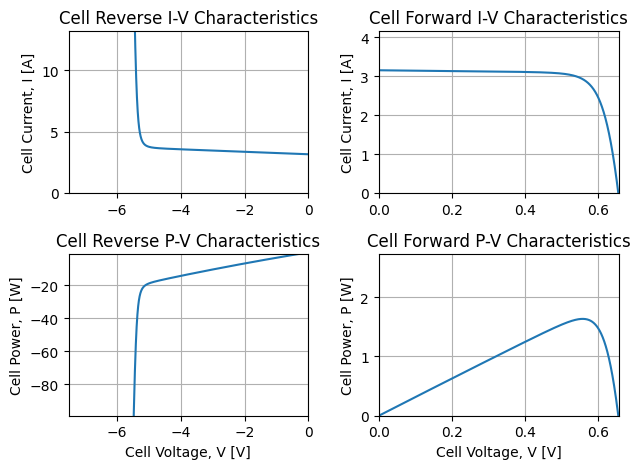

In [27]:
# Plot one of the cell IV curves
from v_pvmismatch.plotting import plot_cell

fig = plot_cell(cell_data, idx_cell=1)

### Calculate IV curves for unique modules with irradiance settings.

In [28]:
# Get unique Ee at module level
Ee_mod, _ = vpvsystem.get_unique_Ee(Ee_vec, search_type='module')
Ee_mod

array([[[0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [0.01, 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ]],

       [[0.5 , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ],
        [1. 

In [29]:
cell_type = np.zeros(idx_map.shape)
outer_circuit = 'series'

In [30]:
# Calculate module IV curves
from v_pvmismatch import vpvmodule

mod_data = vpvmodule.calcMods(cell_pos, pvmodule, idx_map, Ee_mod, Ee_cell, u_cell_type, cell_type, cell_data, outer_circuit)
mod_data.keys()

dict_keys(['Imod', 'Vmod', 'Pmod', 'Isubstr', 'Vsubstr', 'Isubstr_pre_bypass', 'Vsubstr_pre_bypass', 'Bypassed_substr', 'mean_Isc', 'Imp', 'Vmp', 'Pmp', 'Isc', 'Voc', 'FF', 'BPDiode_Active_MPP', 'num_bpd_active', 'full_data'])

In [31]:
# I, V, P curves are Imod, Vmod, Pmod
mod_data['Imod'].shape

(3, 3000)

In [32]:
# Plot one of the module IV curves
from v_pvmismatch.plotting import plot_module

fig = plot_module(mod_data, idx_mod=0, curve='PV')
fig

### Calculate IV curves at the string level

In [33]:
# Get unique Ee at string level
Ee_str, _ = vpvsystem.get_unique_Ee(Ee_vec, search_type='string')

In [34]:
# Calculate string IV curves
from v_pvmismatch import vpvstring

NPT_dict = cell_data['NPT']
str_data = vpvstring.calcStrings(Ee_str, Ee_mod, mod_data, NPT_dict)
str_data.keys()

dict_keys(['Istring', 'Vstring', 'Pstring', 'Bypassed_substr', 'full_data'])

In [35]:
# I, V, P curves are Istring, Vstring, Pstring
str_data['Istring'].shape

(3, 3000)

In [36]:
str_data['Bypassed_substr'].shape

(3, 8, 3, 3000)

In [37]:
# Plot one of the string IV curves & the bypass diode activation flags for the first module
from v_pvmismatch.plotting import plot_string

fig = plot_string(str_data, idx_str=1, idx_mod=0)
fig

### Calculate IV curves at the system level

In [38]:
sys_data = vpvsystem.calcSystem(Ee_vec, Ee_str, str_data, NPT_dict)
sys_data.keys()

dict_keys(['Isys', 'Vsys', 'Psys', 'Bypass_activation', 'Imp', 'Vmp', 'Pmp', 'Isc', 'Voc', 'FF', 'Bypass_Active_MPP', 'num_active_bpd', 'full_data'])

In [39]:
# I, V, P curves are Isys, Vsys, Psys
sys_data['Isys'].shape

(3, 3000)

In [40]:
# We can also look at the number of bypass diodes that activated in the system
sys_data['num_active_bpd']

array([0, 0, 1])

In [41]:
# A look at bypass diode activation for each diode at MPP
sys_data['Bypass_Active_MPP']

array([[[[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]]],


       [[[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False]],

        [[False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],
         [False, False, False],


In [42]:
sys_data['Pmp']

array([5142.93917442, 5105.90686583, 5046.21967633])

In [43]:
sys_data['Bypass_activation'].shape

(3, 2, 8, 3, 3000)

In [44]:
# Plot one of the system IV curves & the bypass diode activation flags for the first module in first string
from v_pvmismatch.plotting import plot_system

fig = plot_system(sys_data, idx_sys=2, idx_str=0, idx_mod=0, curve='IV')
fig

### Estimate the cell currents due to mismatch

We can now estimate the cell current for all cells in the system.

In [45]:
from v_pvmismatch.cell_curr import est_cell_current_DC

cell_curr = est_cell_current_DC(sys_data, str_data, mod_data, idx_map)
cell_curr.keys()

dict_keys(['cell_Imps', 'cell_Iscs', 'cell_Vmps', 'cell_Vscs', 'cell_Pmps', 'cell_Pscs', 'cell_isRev_mp', 'cell_isRev_sc', 'diode_Imps', 'diode_Iscs'])

#### Plots

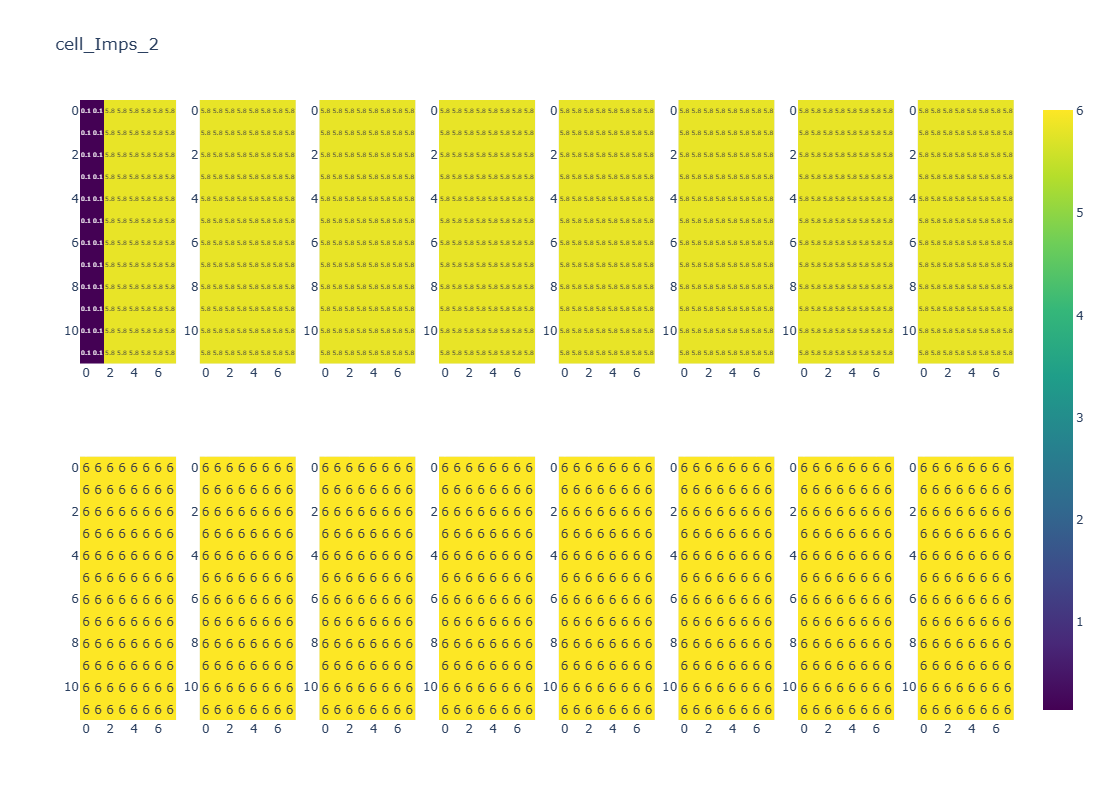

In [46]:
# Plot the cell currents
from v_pvmismatch.plotting import plot_heatmap

fig = plot_heatmap(cell_curr, idx_sim=2, dkey='cell_Imps')
fig

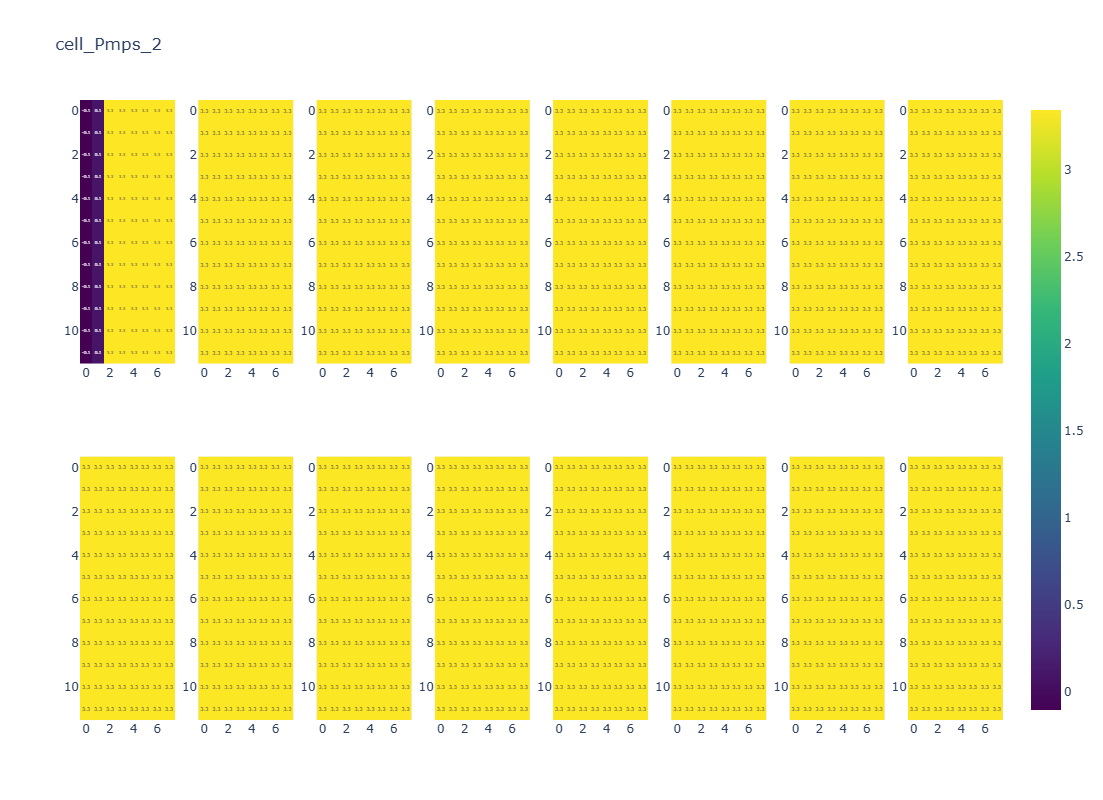

In [47]:
# Plot the cell power dissipation (or generation)

fig = plot_heatmap(cell_curr, idx_sim=2, dkey='cell_Pmps')
fig

In [48]:
# Plot which cells are in reverse

fig = plot_heatmap(cell_curr, idx_sim=2, dkey='cell_isRev_mp', show_vals=False)
fig

In [49]:
# Plot Diode Currents
from v_pvmismatch.plotting import plot_heatmap_diode

fig = plot_heatmap_diode(cell_curr, idx_sim=2, dkey='diode_Imps')
fig

### Modeling the IV curves for systems with Module level power electronics

In [50]:
sys_data = vpvsystem.calcACSystem(Ee_vec, Ee_mod, mod_data, NPT_dict)
sys_data.keys()

dict_keys(['Isys', 'Vsys', 'Psys', 'Bypass_activation', 'Imp', 'Vmp', 'Pmp', 'Isc', 'Voc', 'FF', 'Bypass_Active_MPP', 'num_active_bpd', 'full_data'])

In [51]:
sys_data['Pmp']

array([5142.93917442, 5108.12763319, 5059.62202178])

### Estimate the cell currents due to mismatch

In [52]:
from v_pvmismatch.cell_curr import est_cell_current_AC

cell_curr = est_cell_current_AC(sys_data, idx_map)

In [53]:
fig = plot_heatmap(cell_curr, idx_sim=2, dkey='cell_Imps')
fig

## Other Projects that use PVMismatch

[PVShadeSim](https://github.com/Maxeon-RnD/PVShadeSim) includes a physical model for the PV system and utilizes v_PVMismatch for the electrical modeling. It allows for modeling physical representations of shading on a PV module. Various shade scenarios can be generated with an in-buit database. There are also structured databases for the PV cell and module classes in PVMismatch. 